In [1]:
import scanpy as sc
import pandas as pd # for handling data frames (i.e. data tables)
import numpy as np # for handling numbers, arrays, and matrices
import matplotlib.pyplot as plt # plotting package
import seaborn as sns # plotting package

**Exercise 0**: Before we continue in this notebook with the next steps of the analysis, we need to load our results from the previous notebook using the `sc.read_h5ad` function and assign them to the variable name `adata`. Give it a try!

## Integration and batch effect correction

In [2]:
adata = sc.read_h5ad("PBMC_analysis_SIB_tutorial3.h5ad")

For simple integration tasks, it is worth first trying the algorithm Harmony. The `harmonypy` package is a port of the original tool in R. Harmony uses a variant of singular value decomposition (SVD) to embed the data, then look for mutual nearest neighborhoods of similar cells across batches in the embedding, which it then uses to correct the batch effect in a locally adaptive (non-linear) manner.

In [3]:
import harmonypy as hm

**Exercise 1**: Harmonypy operates on the principal components you previous obtained using the command `sc.tl.pca`. These are stored in your `adata` object under the `.obsm` field as `X_pca`. Can you extract these and store them in a variable named `mat_PC` in order to provide them directly to harmonypy in the following code cell?

In [4]:
mat_PC = adata.obsm["X_pca"]

Next, we run harmony on the data to correct for any batch effects. We must specify with `vars_use` the metadata column name in `adata.obs` that we would like to correct for.

In [5]:
ho = hm.run_harmony(data_mat = mat_PC, meta_data=adata.obs, vars_use=["sample"])

2024-04-25 17:41:12,679 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-04-25 17:41:18,426 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-04-25 17:41:18,525 - harmonypy - INFO - Iteration 1 of 10
2024-04-25 17:41:20,283 - harmonypy - INFO - Iteration 2 of 10
2024-04-25 17:41:22,581 - harmonypy - INFO - Iteration 3 of 10
2024-04-25 17:41:24,569 - harmonypy - INFO - Iteration 4 of 10
2024-04-25 17:41:25,812 - harmonypy - INFO - Iteration 5 of 10
2024-04-25 17:41:27,935 - harmonypy - INFO - Converged after 5 iterations


We can then visualize the extent to which each of the principal components was rescaled by harmonypy to correct for batch effects.

In [6]:
pc_std = np.std(ho.Z_corr, axis=1).tolist()

<Axes: >

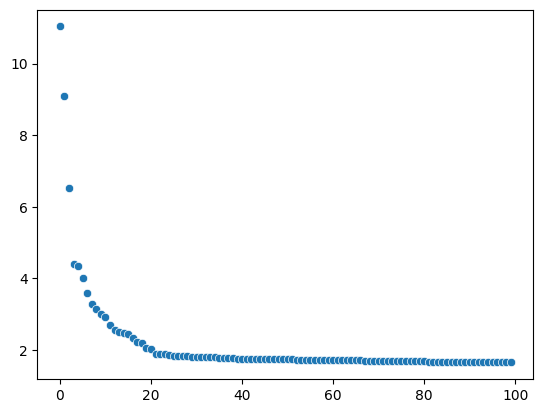

In [7]:
sns.scatterplot(x=range(0, len(pc_std)), y=sorted(pc_std, reverse=True))

Finally, we store the results in our `adata` as `X_pcahm` variable.

In [8]:
adata.obsm["X_pcahm"] = ho.Z_corr.transpose()

**Exercise 2:** Now that we have used harmony to correct for batch effects in our principal components, we want to rerun the `sc.pp.neighbors` and `sc.tl.umap` steps from our previous exercises, to obtain a new UMAP representation. Write those commands out below to obtain your new UMAP. Important: when running `sc.pp.neighbors`, you must specify that you would like to use the harmony-adjusted PCs and not the original, unadjusted ones. To do this, specify the optional argument `use_rep=X_pcahm`!

In [9]:
sc.pp.neighbors(adata, n_pcs=30, use_rep="X_pcahm")
sc.tl.umap(adata)

/home/alex/anaconda3/envs/sib_course_2024/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Exercise 3:** Finally, visualize your UMAP with `sc.pl.umap`. How does the embedding compare to the one obtained prior to running harmony?

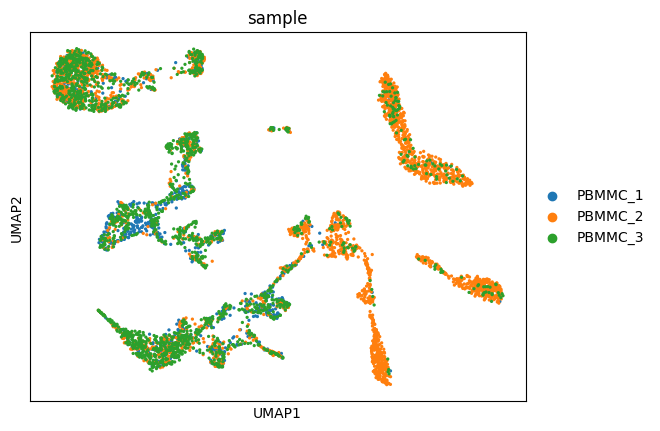

In [10]:
sc.pl.umap(adata, color=["sample"])

In [11]:
adata.write_h5ad("PBMC_analysis_SIB_tutorial4.h5ad") # save your results!